In [1]:
!pip install torch scikit-learn pandas numpy

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np

In [3]:
class Config:
    max_vocab_size = 20000  # Maximum vocabulary size
    max_seq_len = 200       # Maximum sequence length for padding/truncation
    embedding_dim = 128     # Size of word embeddings
    hidden_dim = 64         # Hidden layer size in the model
    batch_size = 32         # Batch size for training and evaluation
    epochs = 5              # Number of training epochs
    learning_rate = 1e-3    # Learning rate for optimizer
    device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Load train data (replace with actual path)
# Paths to your CSV files
file1 = 'C:/Education/ASU/Semester_3/CSE575_SML/Project/Train_Dataset/train_drcat_01.csv'
file2 = 'C:/Education/ASU/Semester_3/CSE575_SML/Project/Train_Dataset/train_drcat_02.csv'
file3 = 'C:/Education/ASU/Semester_3/CSE575_SML/Project/Train_Dataset/train_drcat_03.csv'

# Load each CSV into a DataFrame
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)

# Combine all into one DataFrame
train_df = pd.concat([df1, df2, df3], ignore_index=True)

# Optional: Shuffle the combined dataset
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
# Map labels to integers (0: real, 1: fake)
#train_df['label'] = train_df['generated']

# Tokenize text data (basic tokenization)
def tokenize_text(text, vocab, max_seq_len):
    tokens = text.lower().split()[:max_seq_len]
    return [vocab.get(token, vocab["<UNK>"]) for token in tokens]

# Build vocabulary from training data
def build_vocab(texts, max_vocab_size):
    word_counts = {}
    for text in texts:
        for word in text.lower().split():
            word_counts[word] = word_counts.get(word, 0) + 1
    
    sorted_vocab = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:max_vocab_size]
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(sorted_vocab)}
    vocab["<PAD>"] = 0  # Padding token
    vocab["<UNK>"] = 1  # Unknown token
    return vocab

# Build vocabulary and tokenize data
vocab = build_vocab(train_df['text'], Config.max_vocab_size)
train_df['tokenized'] = train_df['text'].apply(lambda x: tokenize_text(x, vocab, Config.max_seq_len))

# Split into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['tokenized'].tolist(), train_df['label'].tolist(), test_size=0.2, random_state=42)

In [5]:
class FakeTextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Pad or truncate sequences to max_seq_len
        padded_text = text + [0] * (Config.max_seq_len - len(text))
        padded_text = padded_text[:Config.max_seq_len]
        
        return {
            'input_ids': torch.tensor(padded_text, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create DataLoaders
train_dataset = FakeTextDataset(train_texts, train_labels)
val_dataset = FakeTextDataset(val_texts, val_labels)

train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size)

In [6]:
class FakeTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(FakeTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * Config.max_seq_len, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 2)  # Binary classification (real/fake)

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)  # Shape: (batch_size, seq_len, embedding_dim)
        flattened = embeddings.view(embeddings.size(0), -1)  # Flatten embeddings
        hidden_output = self.relu(self.fc1(flattened))
        logits = self.fc2(hidden_output)
        return logits

# Initialize model
model = FakeTextClassifier(len(vocab), Config.embedding_dim, Config.hidden_dim).to(Config.device)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=Config.learning_rate)

for epoch in range(Config.epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        input_ids = batch['input_ids'].to(Config.device)
        labels = batch['label'].to(Config.device)

        optimizer.zero_grad()
        
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

Epoch 1, Loss: 0.0784455883728724
Epoch 2, Loss: 0.008134405626661127
Epoch 3, Loss: 0.008570194038771345
Epoch 4, Loss: 0.009509848258683031
Epoch 5, Loss: 0.0035491380507770413


In [8]:
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(Config.device)
        labels = batch['label'].to(Config.device)

        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

# Metrics
accuracy = accuracy_score(true_labels, predictions)
print(f"Validation Accuracy: {accuracy}")
print(classification_report(true_labels, predictions))

Validation Accuracy: 0.9966160520607376
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17190
           1       1.00      0.99      0.99      5860

    accuracy                           1.00     23050
   macro avg       1.00      0.99      1.00     23050
weighted avg       1.00      1.00      1.00     23050



In [9]:
# Load test data (replace with actual path)
test_df = pd.read_csv('C:/Education/ASU/Semester_3/CSE575_SML/Project/Train_Dataset/train_drcat_04.csv')

# Tokenize test data using the same vocabulary and preprocessing steps as training data
test_df['tokenized'] = test_df['text'].apply(lambda x: tokenize_text(x, vocab, Config.max_seq_len))

# Create test dataset and DataLoader
test_dataset = FakeTextDataset(test_df['tokenized'].tolist(), [0] * len(test_df))  # Labels are dummy here.
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size)

# Inference on test data
model.eval()
test_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(Config.device)

        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        test_predictions.extend(preds)

# Add predictions to the test dataframe (optional)
test_df['predicted_label'] = test_predictions

# Save predictions to CSV (optional)
test_df[['essay_id', 'predicted_label']].to_csv('test_predictions.csv', index=False)

Accuracy: 0.9820
Precision: 0.9988
Recall: 0.9459
F1 Score: 0.9716


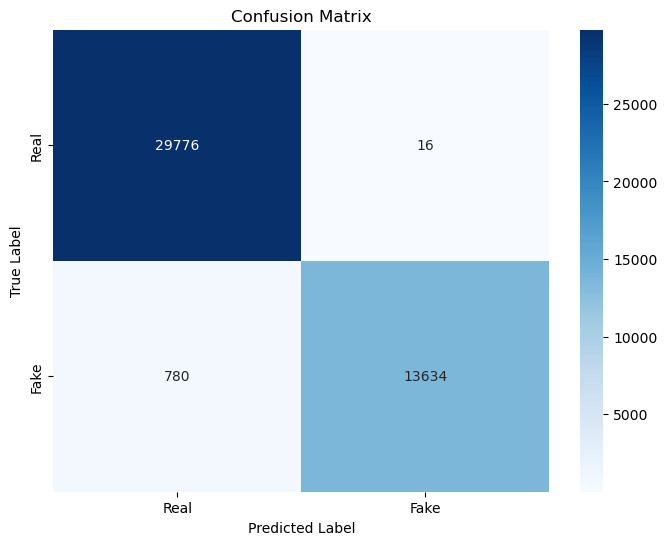

C:\Users\ysaiv\AppData\Local\Temp\ipykernel_38004\2861549385.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')


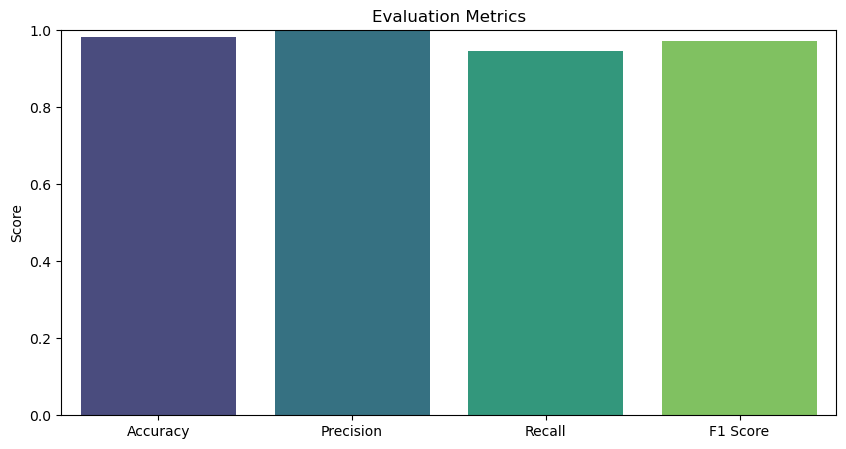

In [10]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load test predictions and true labels
predictions_df = pd.read_csv('test_predictions.csv')  # File containing predicted labels
test_df = pd.read_csv('C:/Education/ASU/Semester_3/CSE575_SML/Project/Train_Dataset/train_drcat_04.csv')     # File containing true labels

# Extract true labels and predicted labels
true_labels = test_df['label']  # Assuming 'generated' column contains true labels
predicted_labels = predictions_df['predicted_label']

# Compute Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot Accuracy vs Other Metrics
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
plt.figure(figsize=(10, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.show()


In [11]:
# Load test data (replace with actual path)
test_df1 = pd.read_csv('C:/Education/ASU/Semester_3/CSE575_SML/Project/ai-ga-dataset.csv')

# Tokenize test data using the same vocabulary and preprocessing steps as training data
test_df1['tokenized'] = test_df1['abstract'].apply(lambda x: tokenize_text(x, vocab, Config.max_seq_len))


# Create test dataset and DataLoader
test_dataset = FakeTextDataset(test_df1['tokenized'].tolist(), [0] * len(test_df))  # Labels are dummy here.
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size)

# Inference on test data
model.eval()
test_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(Config.device)

        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        test_predictions.extend(preds)

# Add predictions to the test dataframe (optional)
test_df1['predicted_label'] = test_predictions

# Save predictions to CSV (optional)
test_df1[['title', 'predicted_label']].to_csv('test_predictions1.csv', index=False)

Accuracy: 0.6373
Precision: 0.6217
Recall: 0.7011
F1 Score: 0.6590


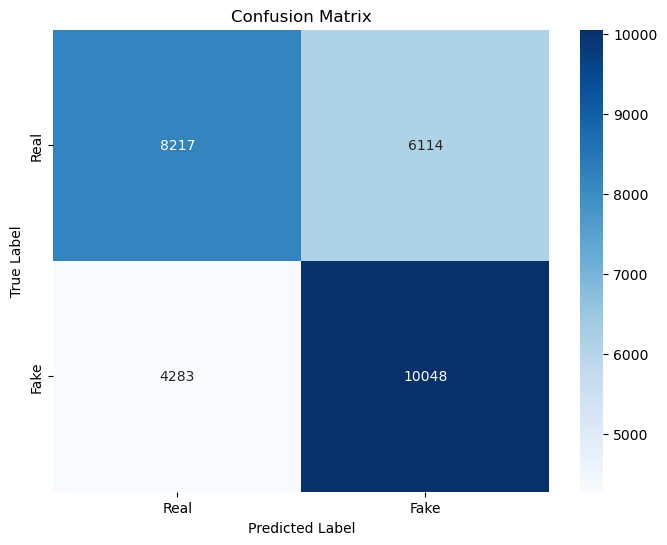

C:\Users\ysaiv\AppData\Local\Temp\ipykernel_38004\900922749.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')


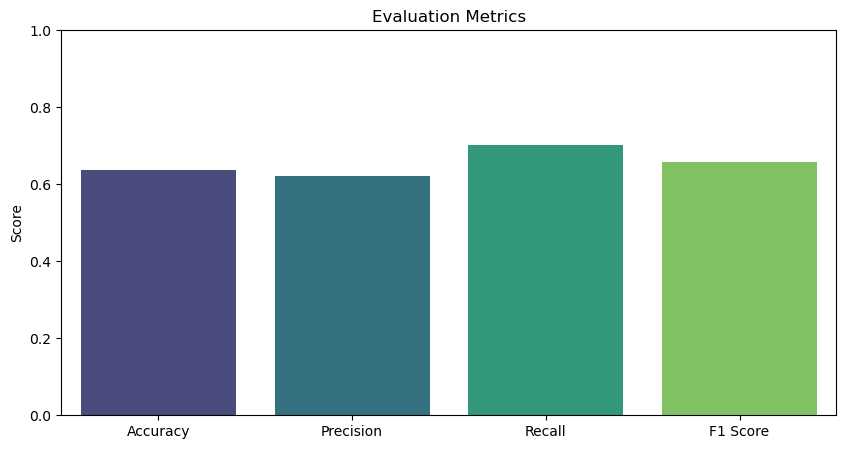

In [12]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load test predictions and true labels
predictions_df = pd.read_csv('test_predictions1.csv')  # File containing predicted labels
test_df = pd.read_csv('C:/Education/ASU/Semester_3/CSE575_SML/Project/ai-ga-dataset.csv')     # File containing true labels

# Extract true labels and predicted labels
true_labels = test_df1['label']  # Assuming 'generated' column contains true labels
predicted_labels = predictions_df['predicted_label']

# Compute Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot Accuracy vs Other Metrics
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
plt.figure(figsize=(10, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.show()

In [15]:
# Load test data (replace with actual path)
test_df = pd.read_csv('C:/Education/ASU/Semester_3/CSE575_SML/Project/ai_human.csv')

# Tokenize test data using the same vocabulary and preprocessing steps as training data
test_df['tokenized'] = test_df['Data'].apply(lambda x: tokenize_text(x, vocab, Config.max_seq_len))

# Create test dataset and DataLoader
test_dataset = FakeTextDataset(test_df['tokenized'].tolist(), [0] * len(test_df))  # Labels are dummy here.
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size)

# Inference on test data
model.eval()
test_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(Config.device)

        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        test_predictions.extend(preds)

# Add predictions to the test dataframe (optional)
test_df['predicted_label'] = test_predictions

# Save predictions to CSV (optional)
test_df[['Data', 'predicted_label']].to_csv('test_predictions.csv', index=False)

Accuracy: 0.7045
Precision: 0.6389
Recall: 1.0000
F1 Score: 0.7797


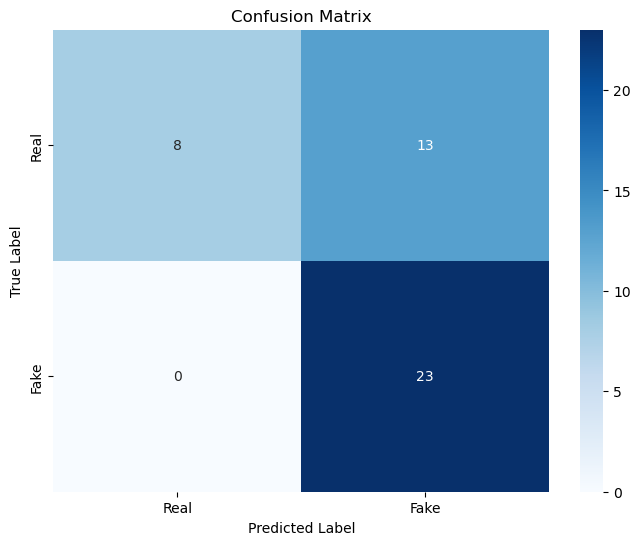

C:\Users\ysaiv\AppData\Local\Temp\ipykernel_38004\485738738.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')


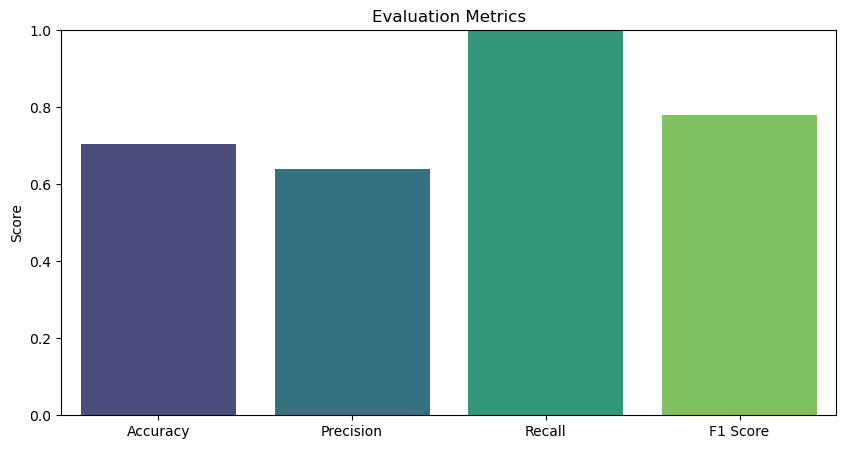

In [17]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load test predictions and true labels
predictions_df = pd.read_csv('test_predictions.csv')  # File containing predicted labels
test_df = pd.read_csv('C:/Education/ASU/Semester_3/CSE575_SML/Project/ai_human.csv')     # File containing true labels

# Extract true labels and predicted labels
true_labels = test_df['Label']  # Assuming 'generated' column contains true labels
predicted_labels = predictions_df['predicted_label']

# Compute Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot Accuracy vs Other Metrics
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
plt.figure(figsize=(10, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.show()